# A Simple Machine Learning Using Iris Dataset

In [5]:
# Import All The Libraries and Dataset
import numpy as np
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Train Tree Classifier

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

# Tree Structure

In [3]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=np.around(values[i], 3),
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node with value=[[0.33  0.304 0.366]]: go to node 1 if X[:, 3] <= 0.800000011920929 else to node 2.
	node=1 is a leaf node with value=[[1. 0. 0.]].
	node=2 is a split node with value=[[0.    0.453 0.547]]: go to node 3 if X[:, 2] <= 4.950000047683716 else to node 4.
		node=3 is a leaf node with value=[[0.    0.917 0.083]].
		node=4 is a leaf node with value=[[0.    0.026 0.974]].


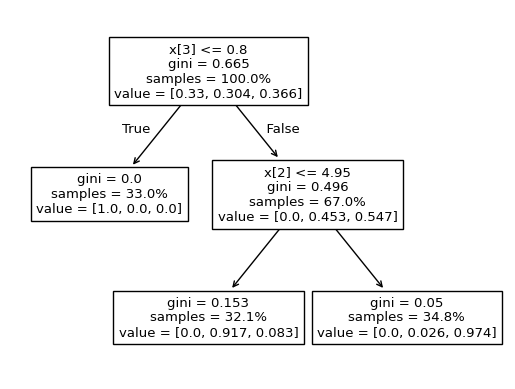

In [4]:
# Display the structure
tree.plot_tree(clf, proportion=True)
plt.show()

# Decision Path

In [6]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 3] = 2.4) > 0.800000011920929)
decision node 2 : (X_test[0, 2] = 5.1) > 4.950000047683716)


For a group of samples, we can determine the common nodes the samples go through.

In [7]:
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print(
    "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
        samples=sample_ids, nodes=common_node_id
    )
)
print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / n_nodes))


The following samples [0, 1] share the node(s) [0 2] in the tree.
This is 40.0% of all nodes.
